# Project: Model Building Notebook

In [1]:
!sed -i 's/hadoop.root.logger=INFO,console/hadoop.root.logger=WARN,console/' /usr/hadoop-3.3.2/etc/hadoop/log4j.properties

In [2]:
# initialize Spark

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import pyspark.sql.functions as F

import os

conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8G'),
                                   ('spark.master', 'local[2]'),
                                   ('spark.app.name', 'PySpark DataFrame Demo')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version, pyspark.version.__version__)

2023-06-01 04:49:36,731 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


3.3.1 3.3.1


In [3]:
#df = spark.read.csv('file:///home/work/project/mas-dse-230/Crimes_-_2001_to_Present.csv', header=True)
df = spark.read.csv('file:///home/work/project/Crimes_-_2001_to_Present.csv', header=True)

1. data cleaning
2. features used
3. train/validation/test sets
4. analysis approach
    <br>a. input: cleaned, filtered training data
    <br>b. setup: create model, cross-validate for hyperparameters
    <br>c. output: final model, predictions, scores
5. challenges encountered
6. post-model analysis, discussion of results

In [4]:
df.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location',
 'Historical Wards 2003-2015',
 'Zip Codes',
 'Community Areas',
 'Census Tracts',
 'Wards',
 'Boundaries - ZIP Codes',
 'Police Districts',
 'Police Beats']

In [5]:
from pyspark.sql.functions import regexp_replace

new_cats = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT','NON-CRIMINAL (SUBJECT SPECIFIED)':'NON-CRIMINAL', 'NON - CRIMINAL':'NON-CRIMINAL',
            'OTHER NARCOTIC VIOLATION':'NARCOTICS','PUBLIC INDECENCY':'PUBLIC INDECENCY/OBSCENITY', 'OBSCENITY':'PUBLIC INDECENCY/OBSCENITY'}

for i in new_cats:
    df = df.replace(i,new_cats[i],"Primary Type")

In [6]:
## Drop NAs

df.select([count(when(col(c).isNotNull(), c)).alias(c) for c in df.columns]).toPandas()

2023-06-01 04:49:41,936 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,7800490,7800486,7800490,7800490,7800490,7800490,7800490,7789988,7800490,7800490,...,7713284,7713284,7690507,7713284,7693607,7695741,7693725,7693660,7694775,7694799


In [7]:
# Count number of NAs for each Year to see if there is any correlation between NA values and year
columns = pd.Series(df.columns)
columns = columns[columns != 'Year']
before_year_na = df.groupBy('Year').count().toPandas()
df2 = df.dropna()
after_year_na = df2.groupBy('Year').count().toPandas()
after_year_na.columns = ['Year', 'count_after']
final_na_counts = before_year_na.merge(after_year_na, on='Year')
final_na_counts['prop_kept'] = final_na_counts['count_after'] / final_na_counts['count']
final_na_counts = final_na_counts.sort_values(by='Year')
final_na_counts

,Year,count,count_after,prop_kept
19,2001,485880,3885,0.007996
8,2002,486804,343581,0.705789
21,2003,475980,469978,0.987390
12,2004,469421,465257,0.991129
7,2005,453771,448002,0.987287
11,2006,448175,443611,0.989816
16,2007,437084,433874,0.992656
15,2008,427167,418048,0.978652
10,2009,392823,384159,0.977944
20,2010,370496,368307,0.994092


In [8]:
df_final = df2.select('Date', 'Primary Type', 'Description', 'Location Description', 'Domestic', 'Beat', 'District',
                      'Ward', 'Zip Codes', 'Arrest')
df_final = df_final.where('Year > 2002 AND Year < 2023')
df_final.show()

+--------------------+---------------+--------------------+--------------------+--------+----+--------+----+---------+------+
|                Date|   Primary Type|         Description|Location Description|Domestic|Beat|District|Ward|Zip Codes|Arrest|
+--------------------+---------------+--------------------+--------------------+--------+----+--------+----+---------+------+
|09/05/2015 01:30:...|        BATTERY|DOMESTIC BATTERY ...|           RESIDENCE|    true|0924|     009|  12|    14924| false|
|09/04/2015 11:30:...|          THEFT|      POCKET-PICKING|             CTA BUS|   false|1511|     015|  29|     4299| false|
|09/05/2015 12:45:...|      NARCOTICS|POSS: HEROIN(BRN/...|            SIDEWALK|   false|1412|     014|  35|    21538|  true|
|09/05/2015 01:00:...|        ASSAULT|              SIMPLE|           APARTMENT|    true|1522|     015|  28|    22216| false|
|09/05/2015 10:55:...|       BURGLARY|      FORCIBLE ENTRY|           RESIDENCE|   false|0614|     006|  21|    21554|

In [9]:
df_length = df_final.count()
df_length

6634666

In [10]:
df_final.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Zip Codes: string (nullable = true)
 |-- Arrest: string (nullable = true)



### Feature Creation

<Axes: xlabel='Month'>

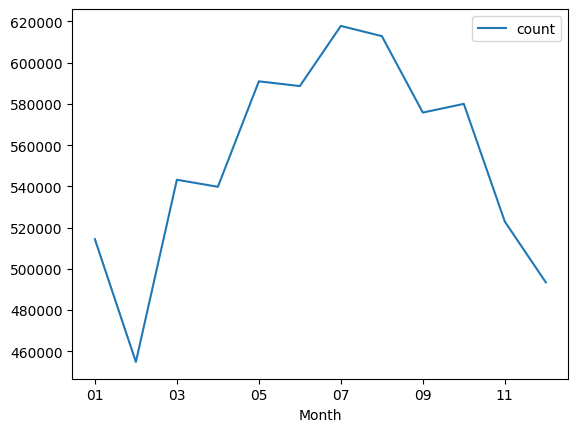

In [11]:
# Make Month column
df_final = df_final.withColumn('Month', substring('Date', 0, 2))
df_final.groupBy('Month').count().toPandas().sort_values('Month').plot(x='Month', y='count')

In [12]:
# Make Hour column
df_final = df_final.withColumn('Hour', from_unixtime(unix_timestamp('Date','MM/dd/yyyy hh:mm:ss a'),'HH'))

<Axes: xlabel='Month'>

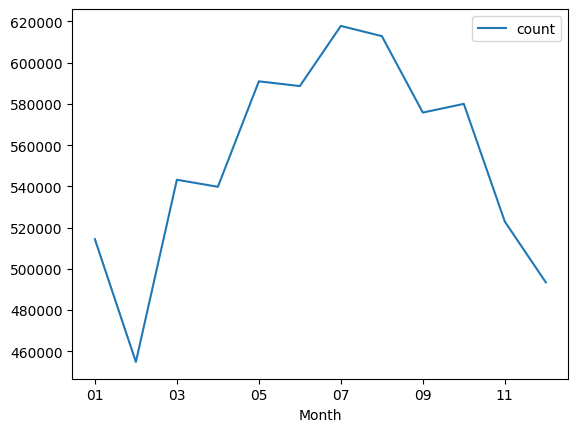

In [13]:
df_final = df_final.withColumn('Hour', substring('Date', 0, 2))
df_final.groupBy('Month').count().toPandas().sort_values('Month').plot(x='Month', y='count')

In [14]:
# Check the Location Description field
df_final.groupBy('Location Description').count().orderBy('count', ascending=False).show(10)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1694146|
|           RESIDENCE|1088372|
|           APARTMENT| 788076|
|            SIDEWALK| 656850|
|               OTHER| 223109|
|PARKING LOT/GARAG...| 169234|
|               ALLEY| 148223|
|  SMALL RETAIL STORE| 127644|
|SCHOOL, PUBLIC, B...| 124179|
|    RESIDENCE-GARAGE| 114583|
+--------------------+-------+
only showing top 10 rows



In [15]:
# Clean up Description field to reduce number of values in the field

print(df_final.select('Description').distinct().count())
mappings = {
    'AGGRAVATED':'AGG',
    'ATTEMPT':'ATT',
    'CRIMINAL':'CRIM',
    'POSSESSION':'POSS',
    'POS ':'POSS',
    'POSESS:':'POSS ',
    'POSESS ':'POSS ',    
    'REGISTRATION':'REG',
    'PRO. ':'PROFESSIONAL ',
    'PO ': 'POLICE OFFICER ',
    'P.O.':'POLICE OFFICER',
    'RITUAL': 'RIT',
    'MUTILATION':'MUT',
    'INSTRUMENT':'INSTR',
    'MANU/DEL:':'MANUFACTURE DELIVER',
    'MANU/DELIVER:':'MANUFACTURE DELIVER',
    'MANUFACTURE / DELIVER':'MANUFACTURE DELIVER'
}
replacement_expr = col('Description')
for k, v in mappings.items():
    replacement_expr = regexp_replace(replacement_expr, k, v)
df_final = df_final.withColumn('Description', replacement_expr)
df_final = df_final.withColumn('Description', regexp_replace(df_final['Description'], '[^A-Za-z0-9]', ''))
print(df_final.select('Description').distinct().count())

538


466


In [16]:
# Recast Arrest field into boolean
df_final = df_final.withColumn('Arrest', col('Arrest').cast('boolean').cast('int'))

# Train/Test split data
We will use train-validation split for hyperparameter tuning, but we need to pass a train_df into the the pipeline and test it on a holdout set.

In [17]:
# Create train/test dataset

df_train, df_test = df_final.randomSplit([0.80, 0.20], seed = 42)

In [18]:
# Check the size

print(df_train.count(),len(df_train.columns))
print(df_test.count(),len(df_test.columns))

5307625 12


1327041 12


# Build Logistic Regression model

In [19]:
# From https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.TrainValidationSplit.html
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel
import tempfile

In [20]:
# Feature Preparation -- need to encode some categorical variables
cols = ['Primary Type', 'Description', 'Location Description', 'Ward', 'Month', 'Hour']

indexers = [
    StringIndexer(inputCol=c, handleInvalid='skip', outputCol='{0}_indexed'.format(c))
    for c in cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol='{0}_encoded'.format(indexer.getOutputCol()))
    for indexer in indexers
]

assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol='features'
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
model_lr = pipeline.fit(df_train)
df_train_enc = model_lr.transform(df_train).select('features', 'Arrest')

# Logistic Regressor
lr = LogisticRegression(labelCol='Arrest')
evaluator = BinaryClassificationEvaluator().setLabelCol('Arrest')

# Build parameter grid
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1, 2, 5])\
    .addGrid(lr.regParam, [1, 2])\
    .build()

# Train Validation Split - grid search
lr_tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2, seed=42)
lr_tvs_model = lr_tvs.fit(df_train_enc)

# Write model
model_path = 'file:///home/work/project/models/logreg'
lr_tvs_model.write().overwrite().save(model_path)


2023-06-01 04:06:45,894 WARN memory.MemoryStore: Not enough space to cache rdd_150_1 in memory! (computed 42.5 MiB so far)
2023-06-01 04:06:46,379 WARN memory.MemoryStore: Not enough space to cache rdd_150_4 in memory! (computed 24.9 MiB so far)
2023-06-01 04:06:46,856 WARN memory.MemoryStore: Not enough space to cache rdd_150_5 in memory! (computed 25.0 MiB so far)
2023-06-01 04:06:47,323 WARN memory.MemoryStore: Not enough space to cache rdd_150_6 in memory! (computed 25.0 MiB so far)
2023-06-01 04:06:48,267 WARN memory.MemoryStore: Not enough space to cache rdd_150_13 in memory! (computed 24.9 MiB so far)
2023-06-01 04:06:48,267 WARN storage.BlockManager: Persisting block rdd_150_13 to disk instead.
2023-06-01 04:06:48,413 WARN memory.MemoryStore: Not enough space to cache rdd_150_12 in memory! (computed 24.9 MiB so far)
2023-06-01 04:06:48,414 WARN storage.BlockManager: Persisting block rdd_150_12 to disk instead.
2023-06-01 04:06:49,762 WARN memory.MemoryStore: Not enough space to

In [21]:
from itertools import chain

lrm = lr_tvs_model.bestModel

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*df_train_enc
        .schema[lrm.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

coef_list = pd.Series([(name, lrm.coefficients[idx]) for idx, name in attrs])
coef_list = pd.DataFrame({'Name': coef_list.apply(lambda x: x[0]), 'Coef': coef_list.apply(lambda x: x[1])})

In [22]:
print('maxIter:', lrm
    ._java_obj     # Get Java object
    .parent()      # Get parent (ALS estimator)
    .getMaxIter())
print('regParam:', lrm
    ._java_obj
    .parent()
    .getRegParam())
print('intercept:', lrm.intercept)
coef_list['Name'] = coef_list['Name'].str.replace('_indexed_encoded_', ': ')
coef_sorted = coef_list.sort_values(by='Coef', ascending=False)

maxIter: 5
regParam: 1.0
intercept: -1.0816303394987081


In [23]:
pd.set_option('max_colwidth', 1000)
coef_sorted[:20]

,Name,Coef
477,Description: AGGPOOTHERDANGEROUSWEAPON,0.642261
437,Description: UNLAWFULUSEOFBODYARMOR,0.621143
464,Description: ARSONISTDUTYTOREGISTER,0.619186
169,Description: GUNOFFENDERANNUALREG,0.617278
126,Description: PAROLEVIOLATION,0.616582
200,Description: GUNOFFENDERDUTYTOREGISTER,0.609776
458,Description: ARSONISTFAILTOREGISTERNEWADDRESS,0.608398
259,Description: GUNOFFENDERDUTYTOREPORTCHANGEOFINFORMATION,0.606739
298,Description: BOARDPLANEWITHWEAPON,0.605317
692,Location Description: PUBLIC HIGH SCHOOL,0.588484


In [24]:
coef_sorted[-20:]

,Name,Coef
444,Description: ATTAGGKNIFECUTTINGINSTR,-0.209886
474,Description: ATTAGGOTHERFIREARM,-0.210019
478,Description: AGGRITMUTKNIFECUTTINGI,-0.211751
473,Description: AGGRITMUTHANDSFISTFEETSERIOUSINJURY,-0.213450
459,Description: COMPELLINGCONFESSION,-0.216220
488,Description: SECONDDEGREEMURDER,-0.220112
469,Description: SALEOFTOBACCOPOLICEOFFICERUCTSTOMINOR,-0.220480
653,Location Description: VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS,-0.221413
486,Description: POLICEOFFICERECTEDEMPOLICEOFFICEREEHANDSNOMININJURY,-0.236322
688,Location Description: LAGOON,-0.252947


### ROC AUC

#### Train

In [25]:
evaluator.evaluate(lr_tvs_model.transform(df_train_enc))

0.8931043393826011

#### Test

In [26]:
df_test_enc = pipeline.fit(df_train).transform(df_test).select('features', 'Arrest')
evaluator.evaluate(lr_tvs_model.transform(df_test_enc))

0.8925501819361745

### Training Accuracy

In [27]:
train_preds = lr_tvs_model.transform(df_train_enc)
train_preds = train_preds.withColumn("prediction", train_preds.prediction.cast('int'))
train_preds = train_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
train_preds = train_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
train_preds.select(mean('isCorrect')).show()

+------------------+
|    avg(isCorrect)|
+------------------+
|0.7995877628882975|
+------------------+



**Training Accuracy**: 79.96%

### Test Accuracy

In [28]:
test_preds = lr_tvs_model.transform(df_test_enc)
test_preds = test_preds.withColumn("prediction", test_preds.prediction.cast('int'))
test_preds = test_preds.withColumn("isCorrect", col('Arrest') == col('prediction'))
test_preds = test_preds.withColumn('isCorrect', col('isCorrect').cast('integer'))
test_preds.select(mean('isCorrect')).show()

+------------------+
|    avg(isCorrect)|
+------------------+
|0.7992438771304105|
+------------------+



**Test Accuracy**: 79.92%

# Vectorize features (non encoded) for Decision Tree / Random Forest models

In [22]:
# Assemble features into single vector column for RF and DT

cols = ['Primary Type', 'Description', 'Location Description', 'Month', 'Hour']

#df_final.withColumn('target')
indexers = [
    StringIndexer(inputCol=c, handleInvalid='keep', outputCol='{0}_indexed'.format(c))
    for c in cols
]

assembler = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCol='features'
)

pipeline = Pipeline(stages=indexers + [assembler])
df_train_vec = pipeline.fit(df_train).transform(df_train).select('features', 'Arrest')
df_test_vec = pipeline.fit(df_train).transform(df_test).select('features', 'Arrest')

# Build Decision Tree model

In [30]:
# Decision Tree

dt = DecisionTreeClassifier(featuresCol='features',labelCol='Arrest',maxBins=463)
evaluator = BinaryClassificationEvaluator().setLabelCol('Arrest')
grid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 4, 5, 10]).build()\

dt_tvs = TrainValidationSplit(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=1, seed=42)
dt_tvs_model = dt_tvs.fit(df_train_vec)

print(dt_tvs_model.getTrainRatio())
model_path = 'file:///home/work/project/models/dectree'
dt_tvs_model.write().overwrite().save(model_path)

train_error = evaluator.evaluate(dt_tvs_model.transform(df_train_vec))

2023-06-01 04:38:52,236 WARN memory.MemoryStore: Not enough space to cache rdd_1022_7 in memory! (computed 19.0 MiB so far)
2023-06-01 04:38:52,237 WARN storage.BlockManager: Persisting block rdd_1022_7 to disk instead.
2023-06-01 04:39:25,929 WARN memory.MemoryStore: Not enough space to cache rdd_1022_14 in memory! (computed 19.0 MiB so far)
2023-06-01 04:39:25,929 WARN storage.BlockManager: Persisting block rdd_1022_14 to disk instead.
2023-06-01 04:39:26,540 WARN memory.MemoryStore: Not enough space to cache rdd_1022_4 in memory! (computed 19.0 MiB so far)
2023-06-01 04:39:27,782 WARN memory.MemoryStore: Not enough space to cache rdd_1022_5 in memory! (computed 19.0 MiB so far)
2023-06-01 04:39:32,868 WARN memory.MemoryStore: Not enough space to cache rdd_1052_8 in memory! (computed 18.4 MiB so far)
2023-06-01 04:39:32,874 WARN memory.MemoryStore: Not enough space to cache rdd_1052_9 in memory! (computed 18.4 MiB so far)
2023-06-01 04:39:33,557 WARN memory.MemoryStore: Not enough sp

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# Predict on test data and evaluate performance

dt_preds = dt_tvs_model.transform(df_test_vec)
dt_preds = dt_preds.withColumn("isCorrect",dt_preds.Arrest == dt_preds.prediction)
dt_preds.groupBy('isCorrect').count().show() # Need to count how many are wrong

# Build Random Forest model

In [116]:
# Random Forest

rf = RandomForestClassifier(labelCol='Arrest',maxBins=463)
evaluator = BinaryClassificationEvaluator().setLabelCol('Arrest')
grid = ParamGridBuilder()\
       .addGrid(rf.maxDepth, [3, 4, 5, 10])\
       .addGrid(rf.numTrees, [3, 5, 7, 10, 15])\
       .build()

rf_tvs = TrainValidationSplit(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=1, seed=42)
rf_tvs_model = rf_tvs.fit(df_train_vec)

print(dt_tvs_model.getTrainRatio())
model_path = 'file:///home/work/project/models/randfor'
rf_tvs_model.write().overwrite().save(model_path)

rf_train_error = evaluator.evaluate(rf_tvs_model.transform(df_train_vec))

2023-05-29 07:37:23,527 WARN execution.CacheManager: Asked to cache already cached data.
2023-05-29 07:37:23,537 WARN execution.CacheManager: Asked to cache already cached data.
2023-05-29 07:38:25,015 WARN memory.MemoryStore: Not enough space to cache rdd_3717_8 in memory! (computed 13.8 MiB so far)
2023-05-29 07:38:25,016 WARN storage.BlockManager: Persisting block rdd_3717_8 to disk instead.
2023-05-29 07:39:52,772 WARN memory.MemoryStore: Not enough space to cache rdd_3799_13 in memory! (computed 29.5 MiB so far)
2023-05-29 07:39:52,835 WARN memory.MemoryStore: Not enough space to cache rdd_3799_14 in memory! (computed 3.7 MiB so far)
2023-05-29 07:39:56,617 WARN memory.MemoryStore: Not enough space to cache rdd_3806_12 in memory! (computed 29.5 MiB so far)
2023-05-29 07:39:56,681 WARN memory.MemoryStore: Not enough space to cache rdd_3806_13 in memory! (computed 29.5 MiB so far)
2023-05-29 07:40:00,463 WARN memory.MemoryStore: Not enough space to cache rdd_3813_12 in memory! (comp

0.75


2023-05-29 08:33:17,919 WARN memory.MemoryStore: Not enough space to cache rdd_7350_10 in memory! (computed 28.0 MiB so far)
2023-05-29 08:33:17,928 WARN memory.MemoryStore: Not enough space to cache rdd_7350_11 in memory! (computed 28.0 MiB so far)
2023-05-29 08:33:19,331 WARN memory.MemoryStore: Not enough space to cache rdd_7350_12 in memory! (computed 28.0 MiB so far)
2023-05-29 08:33:19,366 WARN memory.MemoryStore: Not enough space to cache rdd_7350_13 in memory! (computed 28.0 MiB so far)
2023-05-29 08:33:27,215 WARN memory.MemoryStore: Not enough space to cache rdd_7350_11 in memory! (computed 5.5 MiB so far)
2023-05-29 08:33:27,233 WARN memory.MemoryStore: Not enough space to cache rdd_7350_10 in memory! (computed 12.3 MiB so far)
2023-05-29 08:33:28,860 WARN memory.MemoryStore: Not enough space to cache rdd_7350_12 in memory! (computed 8.2 MiB so far)
2023-05-29 08:33:28,873 WARN memory.MemoryStore: Not enough space to cache rdd_7350_13 in memory! (computed 8.2 MiB so far)
202

In [ ]:
# Predict on test data and evaluate performance

rf_preds = rf_tvs_model.transform(df_test_vec)
rf_preds = rf_preds.withColumn("isCorrect",rf_preds.Arrest == rf_preds.prediction)
rf_preds.groupBy('isCorrect').count().show() # Need to count how many are wrong